#Importing necessary libraries


In [ ]:
#pip install tensorflow transformers

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.datasets import imdb
from transformers import BertTokenizer, TFBertForSequenceClassification

#Importing the Dataset

In [ ]:
# File paths
file_paths = [
    r'city aquarium_.csv',
    r'city botanic Garden_.csv',
    r'city museum_.csv',
    r'city zoo_.csv',
    r'cruise trip_.csv',
    r'sky tower_.csv',
]


#Preprocessing Data

##Concatenating all the given data sets into one named combined_data

In [ ]:
# Read and concatenate all files
dataframes = [pd.read_csv(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

# Display basic information about the combined data
print(combined_data.info())
print(combined_data.head())

# Save the combined dataset to a CSV file
combined_data.to_csv(r'combined_dataset.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2557 non-null   int64 
 1   text    1413 non-null   object
dtypes: int64(1), object(1)
memory usage: 40.1+ KB
None
   label                                               text
0      1                                                NaN
1      1   The City Aquarium was a delight for my family...
2      1   I recently visited the city aquarium and was ...
3      1                                                NaN
4      1   I’ve always enjoyed visiting city aquariums, ...


##Removing all the NaN values


In [ ]:
# Remove rows with NaN values
cleaned_data = combined_data.dropna()

# Display information about the cleaned dataset
print(cleaned_data.info())
print(cleaned_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1413 entries, 1 to 2556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1413 non-null   int64 
 1   text    1413 non-null   object
dtypes: int64(1), object(1)
memory usage: 33.1+ KB
None
   label                                               text
1      1   The City Aquarium was a delight for my family...
2      1   I recently visited the city aquarium and was ...
4      1   I’ve always enjoyed visiting city aquariums, ...
5      1   I enjoyed visiting the city aquarium last wee...
6      1   "Visiting the city aquarium was an enchanting...


## Tokenizing the dataset


In [ ]:
start = '<sos>'
end = '<eos>'

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token='<UNK>',
)

In [ ]:
print(cleaned_data['text'].values)

[' The City Aquarium was a delight for my family. We marveled at the colorful array of fish, from the swift, sleek jellyfish to the ploddng sea turtles. My son, usually a ball of energy, was captivated by the grace of the stingrays as they glided across the tank. The facility was clean and well-organized, making it easy to navigate. The staff was knowledgeable and friendly, explaining details about the marine life and suggesting the best spots to view the penguins and seals. It was'
 ' I recently visited the city aquarium and was completely blown away by the sheer variety of marine life on display. The vibrant colors of the fish, the graceful movements of the rays, and the gentle floating of the jellyfish were captivating. The staff was also incredibly knowledgeable and eager to share insights about the ecosystems and the creatures within. Interacting with the touch tanks was a highlight for both me and my kids, allowing us to connect with the marine world in a meaningful way. The aqua

In [ ]:
text_sentences = start + cleaned_data['text'].values + " "+end

In [ ]:
text_sentences = text_sentences.tolist()
tokenizer.fit_on_texts(text_sentences)

In [ ]:
sequences=tokenizer.texts_to_sequences(text_sentences)

In [ ]:
print(sequences[:3])

[[10, 2, 16, 29, 4, 6, 168, 18, 14, 87, 17, 418, 25, 2, 207, 286, 7, 59, 20, 2, 1380, 1860, 484, 5, 2, 3981, 77, 564, 14, 1033, 918, 6, 2438, 7, 1497, 4, 358, 27, 2, 976, 7, 2, 524, 26, 92, 919, 545, 2, 153, 2, 920, 4, 546, 3, 105, 826, 36, 15, 868, 5, 525, 2, 35, 4, 113, 3, 115, 1498, 752, 44, 2, 84, 47, 3, 1499, 2, 292, 1659, 5, 116, 2, 578, 3, 1034, 15, 4, 9], [10, 8, 334, 66, 2, 16, 29, 3, 4, 456, 457, 222, 27, 2, 260, 154, 7, 84, 47, 22, 201, 2, 41, 137, 7, 2, 59, 2, 383, 869, 7, 2, 603, 3, 2, 228, 717, 7, 2, 484, 13, 313, 2, 35, 4, 64, 74, 113, 3, 335, 5, 385, 407, 44, 2, 921, 3, 2, 108, 495, 1104, 12, 2, 173, 119, 4, 6, 144, 18, 156, 33, 3, 14, 152, 309, 49, 5, 1660, 12, 2, 84, 110, 11, 6, 1861, 172, 2, 29, 64, 1278, 175, 44, 645, 794, 3, 84, 9], [10, 2100, 145, 138, 51, 16, 795, 3, 2, 21, 282, 2439, 214, 11, 2101, 14, 126, 223, 30, 211, 226, 646, 604, 526, 104, 8, 250, 14, 605, 1661, 3, 922, 37, 628, 2102, 510, 3, 647, 26, 92, 418, 25, 2, 207, 59, 2, 278, 524, 3, 2, 511, 272, 5

In [ ]:
l = []
for a in sequences:
  l.append(len(a))

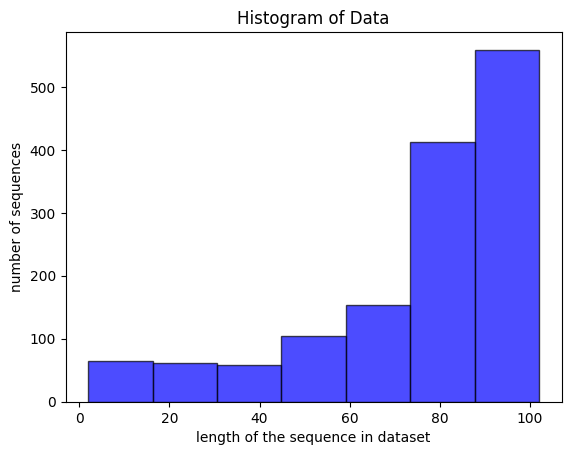

In [ ]:
plt.hist(l, bins=7, color='blue', edgecolor='black', alpha=0.7)

plt.xlabel('length of the sequence in dataset')
plt.ylabel('number of sequences')
plt.title('Histogram of Data')

plt.show()

For now taking all the sequences. If the model doesn't perform better, will try taking sequences from 10 to 100 words.

In [ ]:
max(l)

102

In [ ]:
max_sequence_length = 102

assert max_sequence_length == max(l)

In [ ]:
tokenizer.word_index['<sos>']

10

In [ ]:
last_index = list(tokenizer.index_word.keys())[-1]
print(last_index)

6905


In [ ]:
print(len(tokenizer.index_word.keys()))

6905


##Padding the Sequence to make it of same length


In [ ]:
def prep_text(texts, tokenizer, max_sequence_length):
    # Turns text into into padded sequences.

    #Convert Text Sequences to Number Sequences
    text_sequences = tokenizer.texts_to_sequences(texts)

    #Add Padding to sequences for making them of same length Example: [[1, 2, pad], [2,3,5]]
    return pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post')

#Returns the maximum of all the lengths of all the sequences
max(l)

102

In [ ]:
print(text_sentences[:3])

['<sos> The City Aquarium was a delight for my family. We marveled at the colorful array of fish, from the swift, sleek jellyfish to the ploddng sea turtles. My son, usually a ball of energy, was captivated by the grace of the stingrays as they glided across the tank. The facility was clean and well-organized, making it easy to navigate. The staff was knowledgeable and friendly, explaining details about the marine life and suggesting the best spots to view the penguins and seals. It was <eos>', '<sos> I recently visited the city aquarium and was completely blown away by the sheer variety of marine life on display. The vibrant colors of the fish, the graceful movements of the rays, and the gentle floating of the jellyfish were captivating. The staff was also incredibly knowledgeable and eager to share insights about the ecosystems and the creatures within. Interacting with the touch tanks was a highlight for both me and my kids, allowing us to connect with the marine world in a meaningf

In [ ]:
#Create a variable padded_sequences and assign it the value of prep_text function
text_sentences = start + cleaned_data['text'].values + " "+end
text_sentences = text_sentences.tolist()
padded_sequences = prep_text(text_sentences, tokenizer, max_sequence_length)

#print the first sequence
print("The first padded sequence is:", padded_sequences[0])

#print the length of the first sequence
print("The len of first padded sequence is:",len(padded_sequences[0]))

The first padded sequence is: [  10    2   16   29    4    6  168   18   14   87   17  418   25    2
  207  286    7   59   20    2 1380 1860  484    5    2 3981   77  564
   14 1033  918    6 2438    7 1497    4  358   27    2  976    7    2
  524   26   92  919  545    2  153    2  920    4  546    3  105  826
   36   15  868    5  525    2   35    4  113    3  115 1498  752   44
    2   84   47    3 1499    2  292 1659    5  116    2  578    3 1034
   15    4    9    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
The len of first padded sequence is: 102


In [ ]:
# Write code to check if all sequences inside padded sequence are of the length maximum_sequence_length
def check_length(texts, max_sequence_length): #Removed tokenizer from the parameters
  for sequence in texts: #Changed padded_sequences to texts to align with the function parameter
        if len(sequence)!= max_sequence_length:
            return False
  return True

if check_length(padded_sequences, max_sequence_length): #Calling the function with padded_sequences and max_sequence_length
    print("All sequences have the correct length.")
else:
    print("Some sequences have incorrect lengths.")

All sequences have the correct length.


In [ ]:
print(tokenizer.index_word[1])

<UNK>


In [ ]:
len(padded_sequences)

1413

##Spliting the Data

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(cleaned_data['text'], cleaned_data['label'], test_size=0.3, random_state=42)

In [ ]:
#import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
#3ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
# Convert text to numerical format (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#Model Building

hyperparameter tuning


##Logestic Regression model

In [ ]:
# Train Logistic Regression
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test_tfidf)

In [ ]:
# Evaluate
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       181
           1       0.98      0.99      0.98       243

    accuracy                           0.98       424
   macro avg       0.98      0.98      0.98       424
weighted avg       0.98      0.98      0.98       424



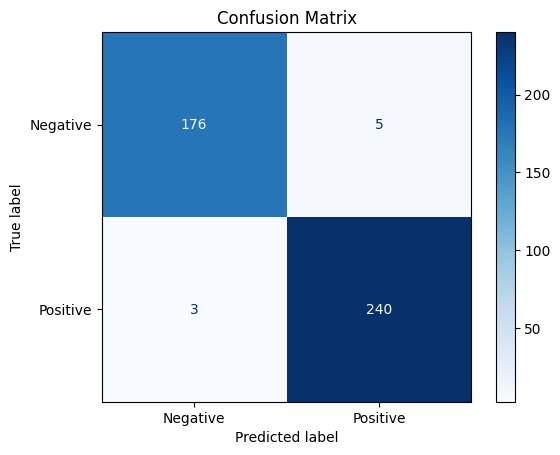

In [ ]:
y_pred_log_reg = log_reg.predict(X_test_tfidf)

# Generate confusion matrix
cm = confusion_matrix(y_test,y_pred_log_reg)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.9811320754716981
F1 Score: 0.9836065573770492
ROC AUC Score: 0.9959984539481164


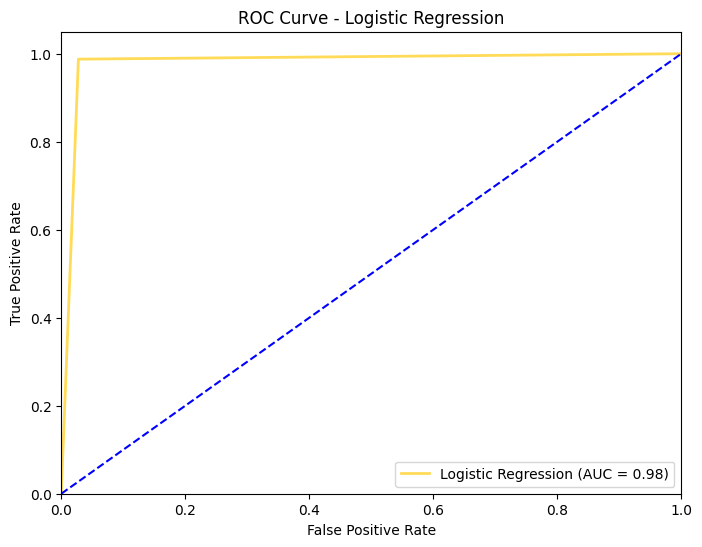

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_tfidf)[:, 1])

# Store in 'best_model'
lr_model = (log_reg, f1, roc_auc)

# Now you can access the elements of 'best_model'
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
y_pred = lr_model[0].predict(X_test_tfidf)
y_probs = lr_model[0].predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#FFDB58', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

##Random forest Model

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       181
           1       0.94      1.00      0.97       243

    accuracy                           0.96       424
   macro avg       0.97      0.96      0.96       424
weighted avg       0.96      0.96      0.96       424



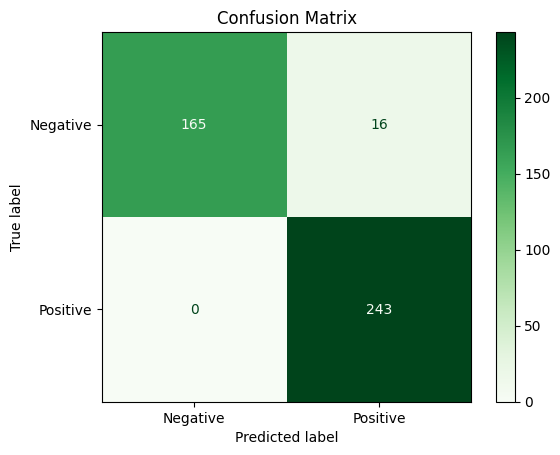

In [ ]:
y_pred_rf= rf.predict(X_test_tfidf)

# Generate confusion matrix
cm = confusion_matrix(y_test,y_pred_rf)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.9622641509433962
F1 Score: 0.9681274900398407
ROC AUC Score: 0.9975558738603552


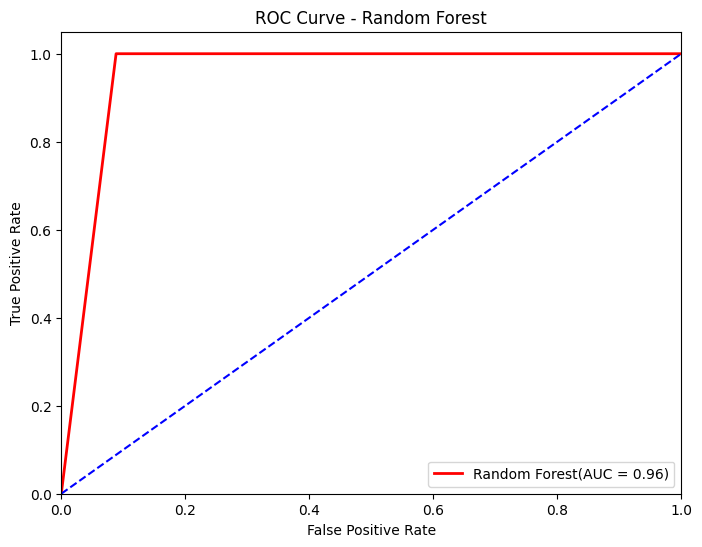

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:, 1])

# Store in 'best_model'
rf_model = (rf, f1, roc_auc)

# Now you can access the elements of 'best_model'
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
y_pred = rf_model[0].predict(X_test_tfidf)
y_probs = rf_model[0].predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='Red', lw=2, label=f'Random Forest(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

##SVM


In [ ]:
# Train SVM model using the transformed data
svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation
print("Support Vector Machine Performance:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       181
           1       0.99      0.99      0.99       243

    accuracy                           0.99       424
   macro avg       0.99      0.99      0.99       424
weighted avg       0.99      0.99      0.99       424



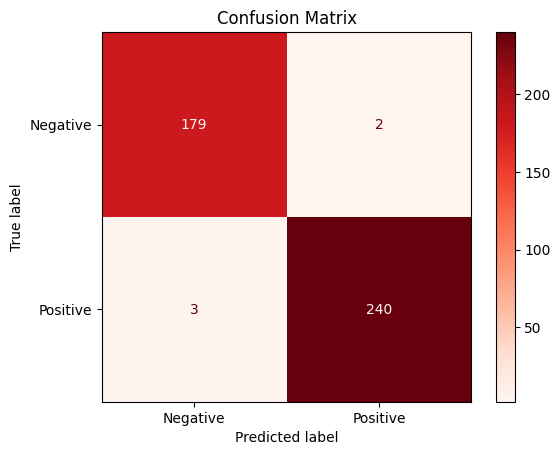

In [ ]:
y_pred_svm= svm_model.predict(X_test_tfidf)

# Generate confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.9882075471698113
F1 Score: 0.9896907216494846
ROC AUC Score: 0.9966350635472797


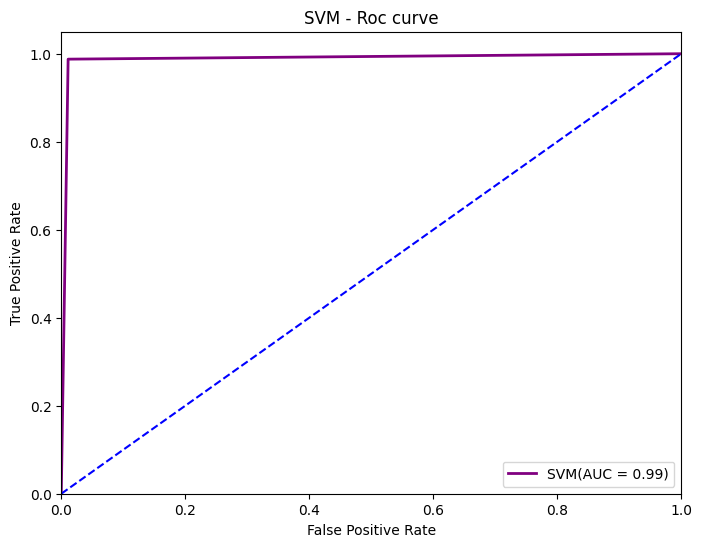

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test_tfidf)[:, 1])

# Store in 'best_model'
svm_model = (svm_model, f1, roc_auc)

# Now you can access the elements of 'best_model'
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
y_pred = svm_model[0].predict(X_test_tfidf)
y_probs = svm_model[0].predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='purple', lw=2, label=f'SVM(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Roc curve')
plt.legend(loc="lower right")
plt.show()

##RNN

In [ ]:
import random
import numpy as np
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, cleaned_data['label'], test_size=0.3, random_state=42, stratify=cleaned_data['label'])

In [ ]:
# Define the LSTM model
RNNmodel = Sequential([
    Embedding(input_dim=10000, output_dim=128, ),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
RNNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
RNNmodel.fit(X_train, y_train.values, epochs=20, batch_size=32, validation_split=0.2)

# Model summary
RNNmodel.summary()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5638 - loss: 0.6828 - val_accuracy: 0.5960 - val_loss: 0.6756
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6209 - loss: 0.6190 - val_accuracy: 0.8131 - val_loss: 0.4492
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8774 - loss: 0.4283 - val_accuracy: 0.9495 - val_loss: 0.2139
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1735 - val_accuracy: 0.9596 - val_loss: 0.1538
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9399 - loss: 0.2089 - val_accuracy: 0.9394 - val_loss: 0.1794
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9518 - loss: 0.1508 - val_accuracy: 0.9646 - val_loss: 0.1295
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9553 - loss: 0.1289 - val_accuracy: 0.9697 - val_loss: 0.1213
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9586 - loss: 0.1144 - val_accuracy: 0.9697 - v

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ (None, 102, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 102, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 102, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,173 (16.72 MB)

 Trainable params: 1,461,057 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,922,116 (11.15 MB)

In [ ]:
# Predictions
y_pred_RNN = RNNmodel.predict(X_test)

# Evaluation
print("Recurrent Neural Network(LSTM) Performance:")
print(classification_report(y_test, y_pred_RNN>=0.5))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Recurrent Neural Network(LSTM) Performance:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       170
           1       0.84      0.97      0.90       254

    accuracy                           0.87       424
   macro avg       0.89      0.84      0.86       424
weighted avg       0.88      0.87      0.86       424



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


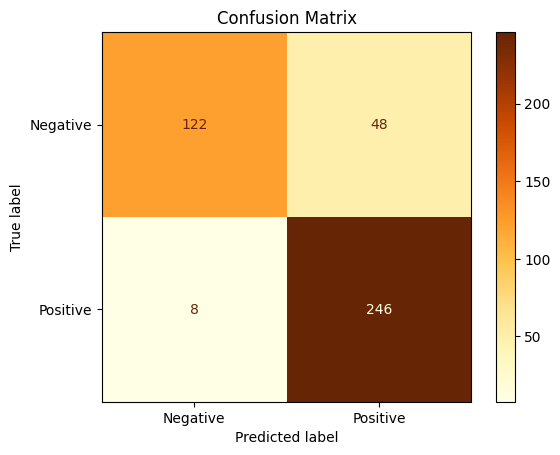

In [ ]:
y_pred_RNN= RNNmodel.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test,y_pred_RNN>=0.5)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.8679245283018868
F1 Score: 0.8978102189781022
ROC AUC Score: 0.882862436313108
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


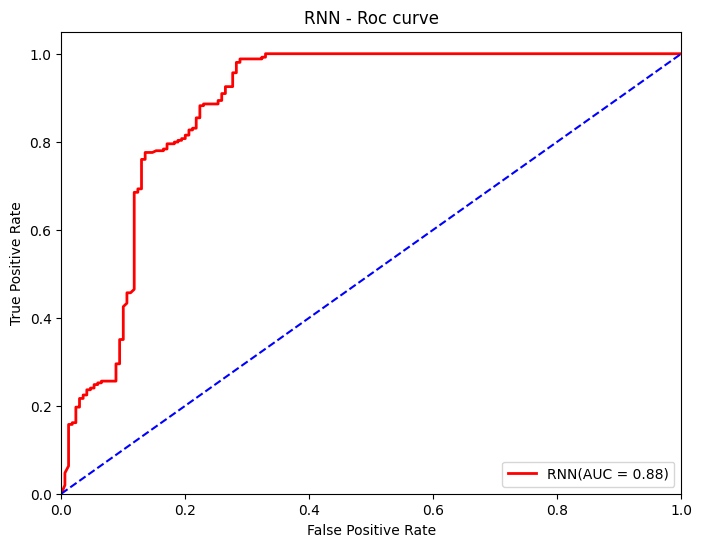

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test.values, (y_pred_RNN>=0.5).flatten().astype("int"))
f1 = f1_score(y_test.values, (y_pred_RNN>=0.5).flatten().astype("int"))
# Instead of RNNmodel[0], use RNNmodel directly to predict
roc_auc = roc_auc_score(y_test, RNNmodel.predict(X_test))

# Store in 'RNN'
RNN = (RNNmodel, f1, roc_auc)

# Now you can access the elements of 'RNN'
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Use RNN[0] to access the original model
y_pred = RNN[0].predict(X_test)
y_probs = RNN[0].predict(X_test)

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_RNN)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'RNN(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN - Roc curve')
plt.legend(loc="lower right")
plt.show()

##BERT Model

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize training and testing data
X_train_ids = tokenizer(
    X_train.tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf"
).input_ids

X_train_mask = tokenizer(
    X_train.tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf"
).attention_mask

X_test_ids = tokenizer(
    X_test.tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf"
).input_ids

X_test_mask = tokenizer(
    X_test.tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf"
).attention_mask

# Prepare inputs for model
train_data = {
    'input_ids': X_train_ids,
    'attention_mask': X_train_mask
}
test_data = {
    'input_ids': X_test_ids,
    'attention_mask': X_test_mask
}

# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Compile
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
model.fit(train_data, tf.convert_to_tensor(y_train), epochs=10, batch_size=16)

# Predict
preds = model.predict(test_data).logits
y_pred = tf.argmax(preds, axis=1).numpy()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
62/62 [==============================] - 68s 376ms/step - loss: 0.2009 - accuracy: 0.9434
Epoch 2/10
62/62 [==============================] - 24s 385ms/step - loss: 0.0305 - accuracy: 0.9939
Epoch 3/10
62/62 [==============================] - 24s 394ms/step - loss: 0.0161 - accuracy: 0.9970
Epoch 4/10
62/62 [==============================] - 25s 403ms/step - loss: 0.0068 - accuracy: 0.9990
Epoch 5/10
62/62 [==============================] - 25s 398ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 6/10
62/62 [==============================] - 25s 398ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 7/10
62/62 [==============================] - 25s 399ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 8/10
62/62 [==============================] - 25s 398ms/step - loss: 9.8898e-04 - accuracy: 1.0000
Epoch 9/10
62/62 [==============================] - 25s 397ms/step - loss: 6.7549e-04 - accuracy: 1.0000
Epoch 10/10
14/14 [==============================] - 6s 235ms/step


In [ ]:
# Evaluation
print("Bert Classiifcation Report")
print(classification_report(y_test, y_pred))


Bert Classiifcation Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       181
           1       0.99      1.00      0.99       243

    accuracy                           0.99       424
   macro avg       0.99      0.99      0.99       424
weighted avg       0.99      0.99      0.99       424



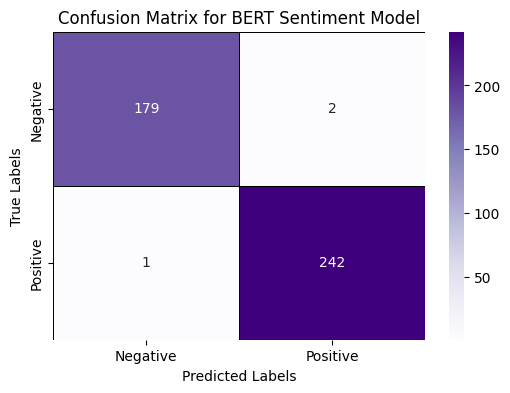

In [ ]:
import seaborn as sns
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], linewidths=0.6, linecolor='black',)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for BERT Sentiment Model')
plt.show()

14/14 [==============================] - 3s 233ms/step


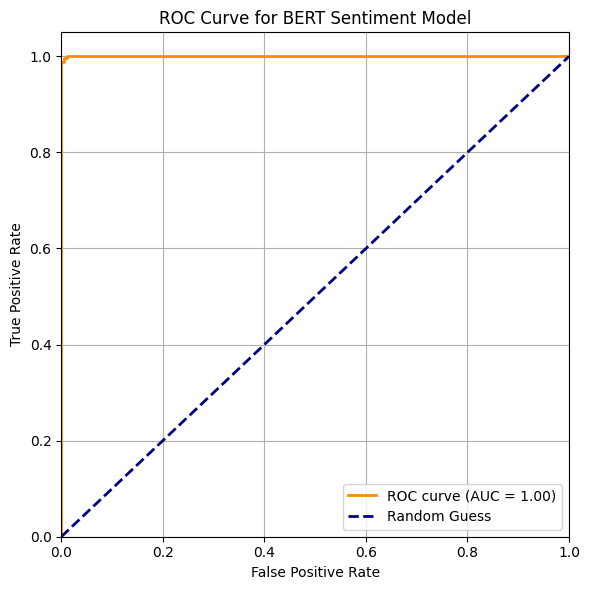

In [ ]:
# Get raw prediction scores (logits)
logits = model.predict(test_data).logits

# Convert logits to probabilities using softmax
probs = tf.nn.softmax(logits, axis=1).numpy()  # shape: (n_samples, 2)
positive_probs = probs[:, 1]  # Probability for class 1 (positive sentiment)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT Sentiment Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()